# 10 - Data Assimilation

## Using ravenpy to perform data assimilation of streamflow to prepare the model states for a forecast.

Here we apply the Ensemble Kalman Filter (EnKF) data assimilation method to the initial states of a `Raven` hydrological model, which will allow improving the estimation of the initial states to reduce the initial model bias. This also helps improve the forecast skill for shorter-term forecasts (up to a few days lead-time), and in some instances, can also improve longer-term forecasts.

We will first start by importing important packages, gathering important datasets and configuration settings as we have seen previously.

In [1]:
import warnings

from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

In [2]:
# Import packages
import datetime as dt
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr

from ravenpy import Emulator, EnsembleReader
from ravenpy.config import commands as rc
from ravenpy.config import options as o
from ravenpy.config.emulators import GR4JCN
from ravenpy.utilities.testdata import get_file

# Import hydrometeorological data
salmon_meteo = get_file(
    "raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc"
)

# Define HRU
hru = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    hru_type="land",
)

# Alternative names for variables in meteo forcing file
alt_names = {
    "RAINFALL": "rain",
    "TEMP_MIN": "tmin",
    "TEMP_MAX": "tmax",
    "SNOWFALL": "snow",
}

# The types of meteorological data available in the file
data_type = ["RAINFALL", "TEMP_MIN", "TEMP_MAX", "SNOWFALL"]

# Additional information about the weather station gauge required by Raven
data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "latitude": hru["latitude"],
        "longitude": hru["longitude"],
    }
}

# Force a test path.
tmp_path = Path(tempfile.mkdtemp())

# Generate the meteorological gauge data required by raven
gauge = [
    rc.Gauge.from_nc(
        salmon_meteo,
        data_type=data_type,
        alt_names=alt_names,
        data_kwds=data_kwds,
    ),
]

### We will now start the assimilation with a spinup period

Data assimilation is best performed on a series of initial states that are already somewhat reasonable. Starting a model from empty states and applying assimilation will work but will take more time to converge, and might in some instances create numerical instability. In this example, we perform a 1-year simulation to generate reasonable model states, and at the last time step, Raven will apply the Ensemble Kalman Filter (EnKF) to assimilate the states for the next step (forecasting or closed-loop assimilation).

In [3]:
# Spin up the model. This period will be used to do an initial spinup, at the end of which the model states
# will be assimilated to better represent the observed streamflow and thus setting up parameters for the next
# steps. We first need to specify the spinup dates:
start_date = dt.datetime(1996, 9, 1)
end_date = dt.datetime(1997, 8, 31)

# Prepare the configuration for the spinup. Since we have added information about Ensemble Kalman Filter data
# assimilation, a ".rve" file will also be written to disk and Raven will use this to perform the assimilation.
conf_spinup = GR4JCN(
    # Model parameters
    params=[0.14, -0.005, 576, 7.0, 1.1, 0.92],
    # Meteorological gauge data from the Salmon river
    Gauge=gauge,
    # Streamflow observations. Very important for data assimilation, or else there is no target to attain.
    ObservationData=[rc.ObservationData.from_nc(salmon_meteo, alt_names="qobs")],
    # Sepcify the HRUs composing the watershed. Here we are using a lumped model, so there is a single HRU.
    HRUs=[hru],
    # Start and end dates of the simulation. EnKF will be applied at the last date (EndDate)
    StartDate=start_date,
    EndDate=end_date,
    # Specify which mode of EnKF we want to use. We want the spinup for now, but later we will use other
    # options. We are also using 25 members in the ensemble, but this can be changed according to your needs.
    EnsembleMode=rc.EnsembleMode(n=25),
    EnKFMode=o.EnKFMode.SPINUP,
    # Run name of the spinup period. This is important because it will be required in the next step.
    RunName="spinup",
    # Let's specify some metrics to assess the model performance.
    EvaluationMetrics=("NASH_SUTCLIFFE",),
    # The folder where the ensemble runs will be generated. By default, the runs are called ens_1... ens_N.
    OutputDirectoryFormat="./ens_*",
    # We need to tell Raven which inputs to perturb. the perturbation is applied following a distribution
    # that should realistically represent the uncertainty of the observations of these variables. Here we
    # use precipitation, but we could also add temperature for example.
    ForcingPerturbation=[
        rc.ForcingPerturbation(
            forcing="PRECIP",
            dist="DIST_NORMAL",
            p1=1.0,
            p2=0.5,
            adj="MULTIPLICATIVE",
        ),
        rc.ForcingPerturbation(
            forcing="TEMP_MAX",
            dist="DIST_NORMAL",
            p1=0.0,
            p2=2.0,
            adj="ADDITIVE",
        ),
        rc.ForcingPerturbation(
            forcing="TEMP_MIN",
            dist="DIST_NORMAL",
            p1=0.0,
            p2=2.0,
            adj="ADDITIVE",
        ),
    ],
    # Define the HRU Groups the assimilation will be applied on. Here we apply to all HRUs (single HRU)
    DefineHRUGroups=["All"],
    HRUGroup=[{"name": "All", "groups": ["1"]}],
    # Define which variables we want to assimilate.
    # Here we only adjust the water content of the 2 first layers of soil (SOIL[0] and SOIL[1])
    AssimilatedState=[
        rc.AssimilatedState(state="SOIL[0]", group="All"),
        rc.AssimilatedState(state="SOIL[1]", group="All"),
    ],
    # Define which subbasin id the streamflow is associated with
    AssimilateStreamflow=[rc.AssimilateStreamflow(sb_id=1)],
    # Define the error model for the observed streamflow. We will have a STD equal to 7% of the streamflow
    # value for each day, following a normal distribution.
    ObservationErrorModel=[
        rc.ObservationErrorModel(
            state="STREAMFLOW",
            dist="DIST_NORMAL",
            p1=1,
            p2=0.07,
            adj="MULTIPLICATIVE",
        )
    ],
    # Set to true for more details (verbosity)
    DebugMode=False,
    NoisyMode=False,
)

# Now that the configuration is completed, we can actually launch Raven to do the assimilation
spinup = Emulator(config=conf_spinup, workdir=tmp_path, overwrite=True).run(
    overwrite=True
)

We have now run the model and obtained an ensemble of simulations that each have perturbed meteorological data and new initial states. We can read-in the generated hydrographs and see what our spinup period flows look like.

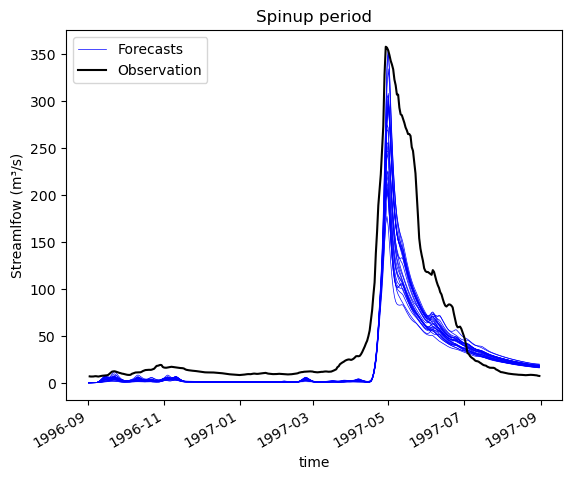

In [4]:
# Get the paths to all the ens_1...ens_N folders, one per member
paths_spinup = list(tmp_path.glob("ens_*"))

# Read those into memory in an EnsembleReader object
ens_spinup = EnsembleReader(run_name=conf_spinup.run_name, paths=paths_spinup)

# We can now plot the results
ens_spinup.hydrograph.q_sim[:, :, 0].plot.line("b", x="time", add_legend=False, lw=0.5)
ens_spinup.hydrograph.q_sim[1, :, 0].plot.line("b", x="time", label="Forecasts", lw=0.5)
ens_spinup.hydrograph.q_obs[1, :, 0].plot.line(
    x="time", color="black", label="Observation"
)
plt.legend(loc="upper left")
plt.ylabel("Streamlfow (m³/s)")
plt.title("Spinup period")
plt.show()

### Start converging model states by closed-loop assimilation
We have completed the spinup period, which has left us with a set of 25 initial states that can be used to sample initial state uncertainty. However, we need to do a few more assimilation passes before the model starts to converge to appropriate values. From the assimilated states of the spinup period, let's now do a single 3-day simulation and see what happens:

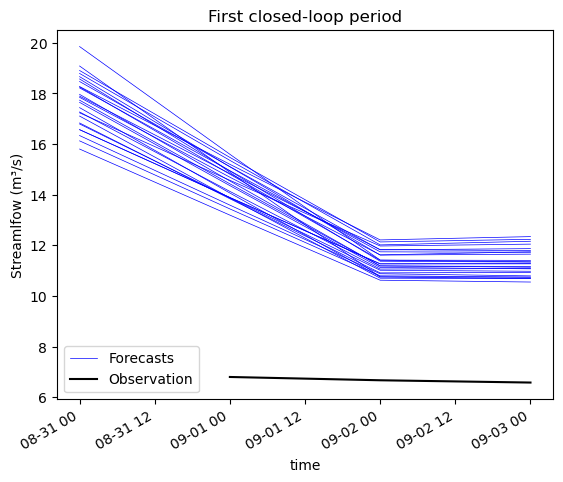

In [5]:
# Set the start date equal to the assimilated date of the prior run, as we want to start from the assimilated
# states. The end date is set 3 days later, after which assimilation will be automatically performed.
start_date = end_date
end_date = end_date + dt.timedelta(days=3)

# Closed-Loop assimilation. From the previous configuration, we can make a copy and only change the required
# parameters, such as the run name, start and end dates, and the type of EnKF (switch from spinup to closed-loop).
conf_loop = conf_spinup.duplicate(
    EnKFMode=o.EnKFMode.CLOSED_LOOP,
    # This will be the name of the output files in the closed-loop run.
    RunName="loop",
    # This is the name of the run we will start from, i.e. the assimilated spinup states from earlier!
    SolutionRunName="spinup",
    # We need to tell the model not to set the default initial conditions (it will use the assimilated states)
    UniformInitialConditions=None,
    # Set the new dates
    StartDate=start_date,
    EndDate=end_date,
)

# Now that the configuration is ready, launch the assimilation run. Raven will run 25 times: Once for each member
# With the same perturbed meteorological and hydrometric data and parameters as defined previously, but for this
# new 3-day period.
loop = Emulator(config=conf_loop, workdir=tmp_path, overwrite=True).run(overwrite=True)

# Get the paths to all the ens_1...ens_N folders, one per member
paths_loop = list(tmp_path.glob("ens_*"))

# Repeat the same process as the spinup to look at model results:
ens_loop = EnsembleReader(run_name=conf_loop.run_name, paths=paths_loop)

# We can now plot the results
ens_loop.hydrograph.q_sim[:, :, 0].plot.line("b", x="time", add_legend=False, lw=0.5)
ens_loop.hydrograph.q_sim[1, :, 0].plot.line("b", x="time", label="Forecasts", lw=0.5)
ens_loop.hydrograph.q_obs[1, :, 0].plot.line(
    x="time", color="black", label="Observation"
)
plt.legend(loc="lower left")
plt.ylabel("Streamlfow (m³/s)")
plt.title("First closed-loop period")
plt.show()

We can see that the assimilation has not converged very well. This is expected, as there have only been 2 assimilation steps performed as of yet: One after the spinup period, and this one that happens 3 days later. We will iterate the assimilation loop to help the model converge after multiple assimilation steps. Here we will loop over 30 steps of 3 days each.

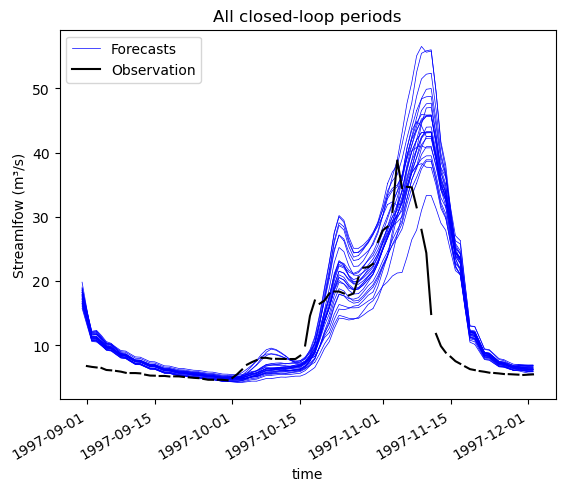

In [6]:
# Let's store the hydrograph from the previous 3-day run in a variable that we will append to at each time step.
total_hydrograph = ens_loop.hydrograph

# Here is where the assimilation loop is performed. We will apply the assimilation 30 successive times, advancing
# in time by 3 days each iteration.
for i in range(0, 30):
    # Set the new start_date and end_dates
    start_date = end_date
    end_date = end_date + dt.timedelta(days=3)

    # Again, copy the configuration object and change some elements
    conf_loop = conf_loop.duplicate(
        # Here we will set RunName and SolutionRunName to the same values such that the model will read the "loop"
        # run, perform the assimilation, and save the results to "loop" again, making them available for the
        # next run, effectively overwriting the results at each step. We could preserve each run's result by changing
        # these run names dynamically, but in our case it is not important nor required to do so.
        RunName="loop",
        SolutionRunName="loop",
        # Again, set the initial conditions to None to preserve the assimilated ones.
        UniformInitialConditions=None,
        # Set the start and end date of the simulation period, with the assimilation being performed on the final date.
        StartDate=start_date,
        EndDate=end_date,
    )

    # Perform the actual simulation and assimilation for this 3-day step.
    new_loop = Emulator(config=conf_loop, workdir=tmp_path, overwrite=True).run(
        overwrite=True
    )

    # Extract the results for this 3-day hydrograph and store it into our "total_hydrograph" which keeps track
    # of the flows for each of the 3-day periods.
    ens_loop = EnsembleReader(run_name=conf_loop.run_name, paths=paths_loop)
    total_hydrograph = xr.concat([total_hydrograph, ens_loop.hydrograph], dim="time")


# Once the loop is complete, plot the results:
total_hydrograph.q_sim[:, :, 0].plot.line("b", x="time", add_legend=False, lw=0.5)
total_hydrograph.q_sim[1, :, 0].plot.line("b", x="time", label="Forecasts", lw=0.5)
total_hydrograph.q_obs[1, :, 0].plot.line(x="time", color="black", label="Observation")
plt.legend(loc="upper left")
plt.ylabel("Streamlfow (m³/s)")
plt.title("All closed-loop periods")
plt.show()

Before going any further, let's compare the assimilated results to those obtained using a simple non-assimilated run (open-loop):

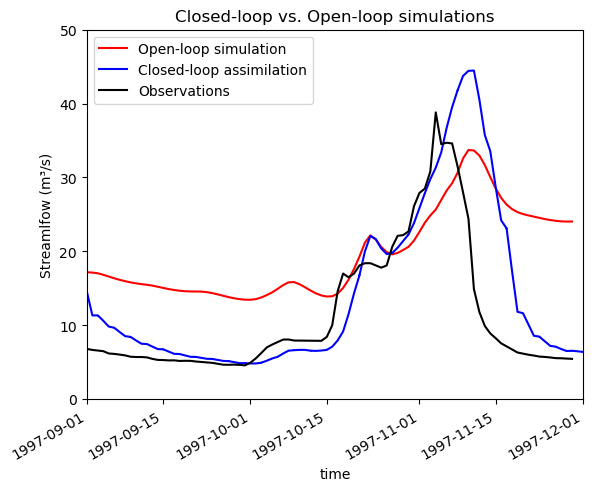

In [7]:
# Reset the start and end-dates to cover the entire period (spinup + 30 3-day steps)
start_date = dt.datetime(1996, 9, 1)
end_date = dt.datetime(1997, 8, 31) + dt.timedelta(days=30 * 3)

# Setup a standard GR4JCN model
conf_openloop = GR4JCN(
    params=[0.14, -0.005, 576, 7.0, 1.1, 0.92],
    Gauge=gauge,
    ObservationData=[rc.ObservationData.from_nc(salmon_meteo, alt_names="qobs")],
    HRUs=[hru],
    StartDate=start_date,
    EndDate=end_date,
    RunName="OPEN_LOOP",
    EvaluationMetrics=("NASH_SUTCLIFFE",),
)

openloop = Emulator(config=conf_openloop, workdir=tmp_path, overwrite=True).run(
    overwrite=True
)

openloop.hydrograph.q_sim.plot.line("r", x="time", label="Open-loop simulation")
total_hydrograph.q_sim[:, :, 0].mean(dim="member").plot.line(
    "b", x="time", label="Closed-loop assimilation"
)
openloop.hydrograph.q_obs.plot.line(x="time", color="black", label="Observations")

plt.xlim([dt.date(1997, 9, 1), dt.date(1997, 12, 1)])
plt.ylim([0, 50])
plt.legend(loc="upper left")
plt.ylabel("Streamlfow (m³/s)")
plt.title("Closed-loop vs. Open-loop simulations")
plt.show()

We can see that the data assimilation as vastly improved most of the hydrograph. Making the assimilation more frequent, changing other state variables, or adjusting the error model hyperparameters could also lead to better simulations.

Once we are satisfied with the initial states, our model would now be ready for forecasting, using the ensemble initial states as initial conditions for generating the forecasts. This can be done using the EnKF forecating method:

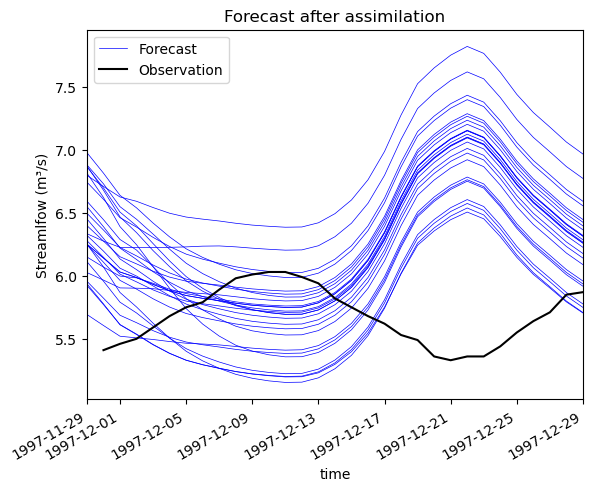

In [8]:
# Set up the forecast configuration, basing it on the previous (final) assimilation step.
conf_forecast = conf_loop.duplicate(
    EnKFMode=o.EnKFMode.FORECAST,
    RunName="forecast",
    SolutionRunName="loop",
    UniformInitialConditions=None,
    # Set the start date equal to the end date of the last assimilation run.
    StartDate=end_date,
    # Here we will do a 30-day forecast using the observed meteorological data as forecast data. However it is
    # possible to replace the Gauge forcing data with that of a forecast, as we have done before.
    EndDate=end_date + dt.timedelta(days=30),
)

forecast = Emulator(config=conf_forecast, workdir=tmp_path, overwrite=True).run(
    overwrite=True
)

# We will plot the resulting forecast. Note that since we have 25 members, we also have 25 forecasts, i.e. one
# per possible initial state. We could take the mean hydrograph to get the best estimator of the forecasted flow.
ens = EnsembleReader(run_name=conf_forecast.run_name, paths=paths_loop)
ens.hydrograph.q_sim[:, :, 0].plot.line("b", x="time", label=None, lw=0.5)
ens.hydrograph.q_sim[1, :, 0].plot.line("b", x="time", label="Forecast", lw=0.5)
ens.hydrograph.q_obs[1, :, 0].plot.line("black", x="time", label="Observation")
plt.legend(loc="upper left")
plt.ylabel("Streamlfow (m³/s)")
plt.title("Forecast after assimilation")
plt.xlim([dt.date(1997, 11, 29), dt.date(1997, 12, 29)])
plt.show()